In [72]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# Base folder is current directory
base_dir = "."

models = ["gpt_4o", "grok_3", "gemini_2"]
corpora = ["original_chinese_corpus", "human_translated_english_corpus", "machine_translated_english_corpus"]
evaluators = ["human_evaluated", "machine_evaluated"]

In [74]:
for corpus in corpora:
    for evaluator in evaluators:
        for model in models:
            file_path = os.path.join(base_dir, corpus, evaluator, f"results_{model}.json")
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            # Fix is_hallucination field
            for record in data:
                value = record.get('is_hallucination')
                if isinstance(value, str):
                    value_lower = value.lower()
                    if value_lower == "true":
                        record['is_hallucination'] = True
                    elif value_lower == "false":
                        record['is_hallucination'] = False
                    elif value == "Invalid_Judge":
                        record['is_hallucination'] = True  # Treat Invalid_Judge as hallucination
                    else:
                        print(f"Unknown value found: {value} at question_id {record.get('question_id')}")
                        # up to you to skip or keep, here we keep

            # Overwrite the JSON file
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)

            print(f"Fixed {file_path}")

Fixed ./original_chinese_corpus/human_evaluated/results_gpt_4o.json
Fixed ./original_chinese_corpus/human_evaluated/results_grok_3.json
Fixed ./original_chinese_corpus/human_evaluated/results_gemini_2.json
Fixed ./original_chinese_corpus/machine_evaluated/results_gpt_4o.json
Fixed ./original_chinese_corpus/machine_evaluated/results_grok_3.json
Fixed ./original_chinese_corpus/machine_evaluated/results_gemini_2.json
Fixed ./human_translated_english_corpus/human_evaluated/results_gpt_4o.json
Fixed ./human_translated_english_corpus/human_evaluated/results_grok_3.json
Fixed ./human_translated_english_corpus/human_evaluated/results_gemini_2.json
Fixed ./human_translated_english_corpus/machine_evaluated/results_gpt_4o.json
Fixed ./human_translated_english_corpus/machine_evaluated/results_grok_3.json
Fixed ./human_translated_english_corpus/machine_evaluated/results_gemini_2.json
Fixed ./machine_translated_english_corpus/human_evaluated/results_gpt_4o.json
Fixed ./machine_translated_english_cor

In [75]:
data = {
    "Corpus": [
        "Original Chinese", "Original Chinese", "Original Chinese",
        "Human Translated English", "Human Translated English", "Human Translated English",
        "Machine Translated English", "Machine Translated English", "Machine Translated English"
    ],
    "Model": [
        "GPT-4o", "Grok-3", "Gemini-2",
        "GPT-4o", "Grok-3", "Gemini-2",
        "GPT-4o", "Grok-3", "Gemini-2"
    ],
    "Human Evaluated Non-Hallucination Rate (%)": [
        53.33, 60.67, 73.78,
        56.67, 70.00, 74.22,
        58.00, 59.11, 72.67
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Pivot it
pivot_df = df.pivot(index="Corpus", columns="Model", values="Human Evaluated Non-Hallucination Rate (%)")

# Show the pivot table
print(pivot_df)

# Optionally export
# pivot_df.to_csv("human_eval_rates_pivoted.csv")


# Optionally export to CSV if you want to edit in Excel/Numbers
# df.to_csv("human_eval_rates_table.csv", index=False)


Model                       GPT-4o  Gemini-2  Grok-3
Corpus                                              
Human Translated English     56.67     74.22   70.00
Machine Translated English   58.00     72.67   59.11
Original Chinese             53.33     73.78   60.67


In [76]:
with open("HalluQA_EN_human.json", "r", encoding="utf-8") as f:
    halluqa_data = json.load(f)

# Create dictionary: {question_id: Class}
id_to_class = {item["question_id"]: item["Class"] for item in halluqa_data}

# Show part of the result
for k, v in list(id_to_class.items())[:5]:  # show first 5 pairs
    print(f"Question ID {k}: {v}")

Question ID 1: Other
Question ID 2: Other
Question ID 3: Other
Question ID 4: Other
Question ID 5: Other


In [77]:

# Load the HalluQA class mapping first
with open("HalluQA_EN_human.json", "r", encoding="utf-8") as f:
    halluqa_data = json.load(f)

# Create id -> class mapping
id_to_class = {item["question_id"]: item["Class"] for item in halluqa_data}

# Now build the master data structure
base_dir = "."  # assuming you're running from evaluation_results
models = ["gpt_4o", "grok_3", "gemini_2"]
corpora = ["original_chinese_corpus", "human_translated_english_corpus", "machine_translated_english_corpus"]
evaluators = ["human_evaluated", "machine_evaluated"]

# The giant dictionary
master_data = {}

for corpus in corpora:
    master_data[corpus] = {}
    for evaluator in evaluators:
        master_data[corpus][evaluator] = {}
        for model in models:
            file_path = os.path.join(base_dir, corpus, evaluator, f"results_{model}.json")
            if not os.path.exists(file_path):
                print(f"Missing: {file_path}")
                continue

            with open(file_path, "r", encoding="utf-8") as f:
                model_data = json.load(f)

            # Prepare a cleaned list
            records = []
            for record in model_data:
                question_id = record.get("question_id")
                is_hallucination = record.get("is_hallucination")

                # Look up the class from HalluQA reference
                question_class = id_to_class.get(question_id, "Unknown")

                records.append({
                    "question_id": question_id,
                    "is_hallucination": is_hallucination,
                    "Class": question_class
                })

            master_data[corpus][evaluator][model] = records

print("Done building master data!")


Done building master data!


In [78]:
# Initialize empty list to collect results
results = []

# Loop through corpora and models
for corpus in master_data:
    for model in master_data[corpus]["human_evaluated"]:  # focus on human evaluated
        records = master_data[corpus]["human_evaluated"][model]

        total = len(records)
        non_hallucinated = sum(1 for r in records if not r["is_hallucination"])

        if total == 0:
            rate = None
        else:
            rate = (non_hallucinated / total) * 100  # percentage

        # Store result
        results.append({
            "Corpus": corpus,
            "Model": model,
            "Human Evaluated Non-Hallucination Rate (%)": round(rate, 2)
        })

# Make it a DataFrame
import pandas as pd
df_check = pd.DataFrame(results)

# Show the result
print(df_check)


                              Corpus     Model  \
0            original_chinese_corpus    gpt_4o   
1            original_chinese_corpus    grok_3   
2            original_chinese_corpus  gemini_2   
3    human_translated_english_corpus    gpt_4o   
4    human_translated_english_corpus    grok_3   
5    human_translated_english_corpus  gemini_2   
6  machine_translated_english_corpus    gpt_4o   
7  machine_translated_english_corpus    grok_3   
8  machine_translated_english_corpus  gemini_2   

   Human Evaluated Non-Hallucination Rate (%)  
0                                       53.33  
1                                       65.11  
2                                       73.78  
3                                       56.67  
4                                       68.44  
5                                       74.22  
6                                       58.00  
7                                       59.78  
8                                       72.67  


## Human vs Machine evaluator.

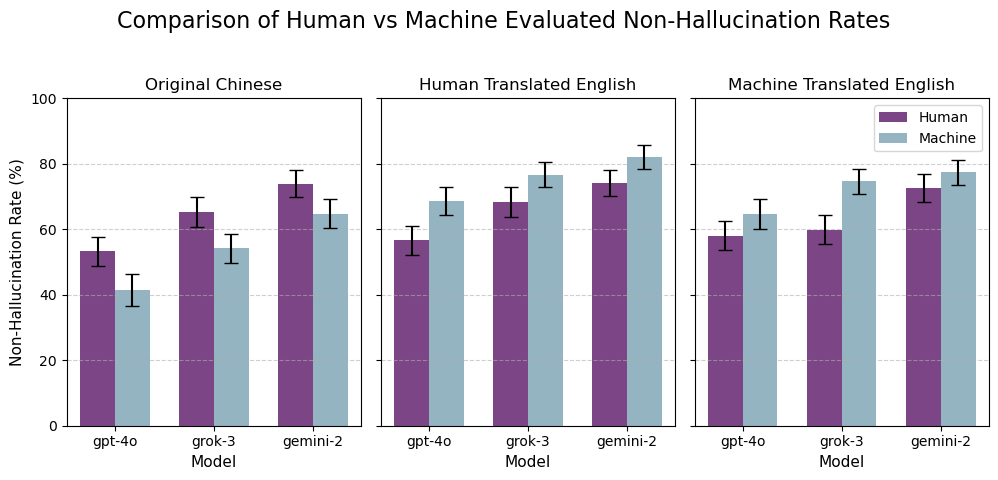

In [120]:
def bootstrap_mean_confidence_interval(data, num_samples=1000, confidence=0.95):
    bootstrapped_means = []
    n = len(data)
    for _ in range(num_samples):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower = np.percentile(bootstrapped_means, (1-confidence)/2 * 100)
    upper = np.percentile(bootstrapped_means, (1 + confidence)/2 * 100)
    return np.mean(bootstrapped_means), lower, upper

# Build the table
results = []

for corpus in master_data:
    for evaluator in ["human_evaluated", "machine_evaluated"]:
        for model in master_data[corpus][evaluator]:
            records = master_data[corpus][evaluator][model]
            if len(records) == 0:
                continue
            correct_flags = [not r["is_hallucination"] for r in records]
            mean, lower, upper = bootstrap_mean_confidence_interval(correct_flags)
            results.append({
                "Corpus": corpus,
                "Model": model,
                "Evaluator": "Human" if evaluator == "human_evaluated" else "Machine",
                "Non_Hallucination_Rate (%)": round(mean*100, 2),
                "Lower Bound": round(lower*100, 2),
                "Upper Bound": round(upper*100, 2)
            })

df_plot = pd.DataFrame(results)
df_plot["Model"] = df_plot["Model"].str.replace("_", "-")

corpus_mapping = {
    "original_chinese_corpus": "Original Chinese",
    "human_translated_english_corpus": "Human Translated English",
    "machine_translated_english_corpus": "Machine Translated English"
}

# Custom colors
custom_colors = {
    "Human": "#7C4585",    # Orchid
    "Machine": "#94B4C1"   # PowderBlue
}

# Prepare the 1-row 3-column figure
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)  # Make each panel taller and thinner

for idx, (corpus_code, corpus_label) in enumerate(corpus_mapping.items()):
    ax = axes[idx]
    subset = df_plot[df_plot["Corpus"] == corpus_code]

    width = 0.35
    x = np.arange(len(subset["Model"].unique()))
    models = subset["Model"].unique()

    for i, evaluator in enumerate(["Human", "Machine"]):
        eval_subset = subset[subset["Evaluator"] == evaluator]
        ax.bar(x + i*width, eval_subset["Non_Hallucination_Rate (%)"], width=width,
               label=evaluator, color=custom_colors[evaluator],
               yerr=[eval_subset["Non_Hallucination_Rate (%)"] - eval_subset["Lower Bound"], 
                     eval_subset["Upper Bound"] - eval_subset["Non_Hallucination_Rate (%)"]],
               capsize=5)

    ax.set_title(corpus_label, fontsize=12)
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(models, fontsize=10)
    ax.set_xlabel("Model", fontsize=11)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    if idx == 0:
        ax.set_ylabel("Non-Hallucination Rate (%)", fontsize=11)
    if idx == 2:
        ax.legend(fontsize=10)

plt.suptitle("Comparison of Human vs Machine Evaluated Non-Hallucination Rates", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.ylim(0, 100)
plt.show()


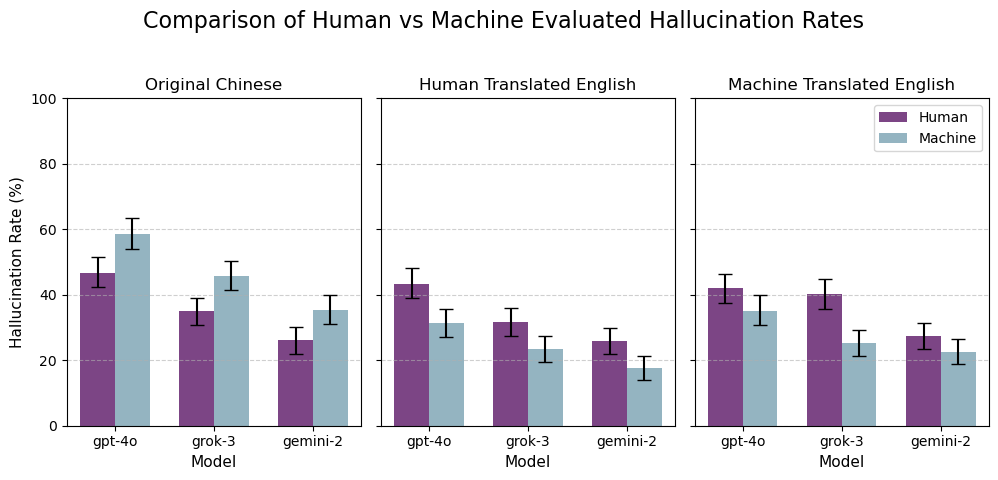

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bootstrap function (same structure)
def bootstrap_mean_confidence_interval(data, num_samples=1000, confidence=0.95):
    bootstrapped_means = []
    n = len(data)
    for _ in range(num_samples):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower = np.percentile(bootstrapped_means, (1-confidence)/2 * 100)
    upper = np.percentile(bootstrapped_means, (1 + confidence)/2 * 100)
    return np.mean(bootstrapped_means), lower, upper

# Build the table (NOW focusing on hallucination rates)
results = []

for corpus in master_data:
    for evaluator in ["human_evaluated", "machine_evaluated"]:
        for model in master_data[corpus][evaluator]:
            records = master_data[corpus][evaluator][model]
            if len(records) == 0:
                continue
            hallucination_flags = [r["is_hallucination"] for r in records]  # <-- NOT `not`, just direct
            mean, lower, upper = bootstrap_mean_confidence_interval(hallucination_flags)
            results.append({
                "Corpus": corpus,
                "Model": model,
                "Evaluator": "Human" if evaluator == "human_evaluated" else "Machine",
                "Hallucination_Rate (%)": round(mean*100, 2),
                "Lower Bound": round(lower*100, 2),
                "Upper Bound": round(upper*100, 2)
            })

df_plot = pd.DataFrame(results)
df_plot["Model"] = df_plot["Model"].str.replace("_", "-")

corpus_mapping = {
    "original_chinese_corpus": "Original Chinese",
    "human_translated_english_corpus": "Human Translated English",
    "machine_translated_english_corpus": "Machine Translated English"
}

# Custom colors
custom_colors = {
    "Human": "#7C4585",    # Orchid
    "Machine": "#94B4C1"   # PowderBlue
}

# Prepare the 1-row 3-column figure
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

for idx, (corpus_code, corpus_label) in enumerate(corpus_mapping.items()):
    ax = axes[idx]
    subset = df_plot[df_plot["Corpus"] == corpus_code]

    width = 0.35
    x = np.arange(len(subset["Model"].unique()))
    models = subset["Model"].unique()

    for i, evaluator in enumerate(["Human", "Machine"]):
        eval_subset = subset[subset["Evaluator"] == evaluator]
        ax.bar(x + i*width, eval_subset["Hallucination_Rate (%)"], width=width,
               label=evaluator, color=custom_colors[evaluator],
               yerr=[eval_subset["Hallucination_Rate (%)"] - eval_subset["Lower Bound"], 
                     eval_subset["Upper Bound"] - eval_subset["Hallucination_Rate (%)"]],
               capsize=5)

    ax.set_title(corpus_label, fontsize=12)
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(models, fontsize=10)
    ax.set_xlabel("Model", fontsize=11)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    if idx == 0:
        ax.set_ylabel("Hallucination Rate (%)", fontsize=11)
    if idx == 2:
        ax.legend(fontsize=10)

plt.suptitle("Comparison of Human vs Machine Evaluated Hallucination Rates", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.ylim(0, 100)
plt.show()


In [122]:
# Map corpus names for display
corpus_mapping = {
    "original_chinese_corpus": "Original Chinese",
    "human_translated_english_corpus": "Human Translated English",
    "machine_translated_english_corpus": "Machine Translated English"
}
df_plot["Corpus"] = df_plot["Corpus"].map(corpus_mapping)

# Now: Split first (filter each corpus first!)
df_original = df_plot[df_plot["Corpus"] == "Original Chinese"].reset_index(drop=True)
df_human_translated = df_plot[df_plot["Corpus"] == "Human Translated English"].reset_index(drop=True)
df_machine_translated = df_plot[df_plot["Corpus"] == "Machine Translated English"].reset_index(drop=True)

# Then: drop the 'Corpus' column after splitting
df_original = df_original.drop(columns=["Corpus"])
df_human_translated = df_human_translated.drop(columns=["Corpus"])
df_machine_translated = df_machine_translated.drop(columns=["Corpus"])

# Display nicely
print("==== Original Chinese Corpus ====")
print(df_original)
print("\n==== Human Translated English Corpus ====")
print(df_human_translated)
print("\n==== Machine Translated English Corpus ====")
print(df_machine_translated)


==== Original Chinese Corpus ====
      Model Evaluator  Hallucination_Rate (%)  Lower Bound  Upper Bound
0    gpt-4o     Human                   46.74        42.22        51.56
1    grok-3     Human                   34.96        30.88        39.11
2  gemini-2     Human                   26.17        21.78        30.23
3    gpt-4o   Machine                   58.71        54.00        63.33
4    grok-3   Machine                   45.79        41.33        50.23
5  gemini-2   Machine                   35.42        31.11        39.78

==== Human Translated English Corpus ====
      Model Evaluator  Hallucination_Rate (%)  Lower Bound  Upper Bound
0    gpt-4o     Human                   43.43        38.89        48.22
1    grok-3     Human                   31.57        27.33        36.00
2  gemini-2     Human                   25.80        21.78        29.78
3    gpt-4o   Machine                   31.36        27.11        35.78
4    grok-3   Machine                   23.36        19.56 

## Class-wise EDA

In [81]:
# Load the HalluQA question sheet
with open("HalluQA_EN_human.json", "r", encoding="utf-8") as f:
    halluqa_data = json.load(f)

# Create a DataFrame
df_questions = pd.DataFrame(halluqa_data)

# Count how many questions per Class
class_counts = df_questions["Class"].value_counts()

# Show result
print("==== Number of Questions per Class ====")
print(class_counts)

==== Number of Questions per Class ====
Class
History                46
Common Sense           45
Science                32
Literature             31
Geography              27
Poetry                 25
Ancient Literature     22
Television and Film    18
Other                  18
Sports                 16
Music                  15
Education              15
Idioms                 14
Diet                   13
Myths and Legends      12
Health                 12
Pseudoscience          11
Stereotypes            11
Paranormal Events      10
Art                    10
Superstition           10
Famous Figures          8
Advertisement           7
Science Fiction         5
Economics               4
Games                   4
Customs                 4
Nature                  3
Famous Quotes           2
Name: count, dtype: int64


### Class-wise hallucination rate

#### Original corpus

/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/415287372.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_rates = df_model.groupby("Class").apply(
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/415287372.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_rates = df_model.groupby("Class").apply(
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_5

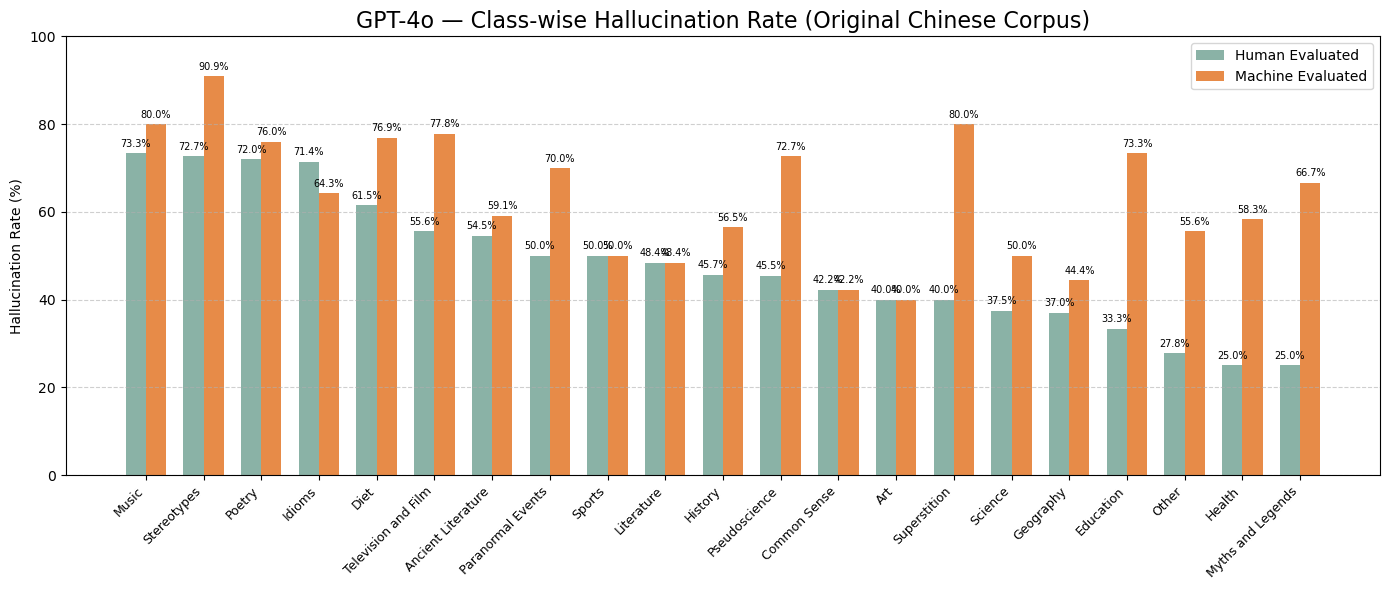

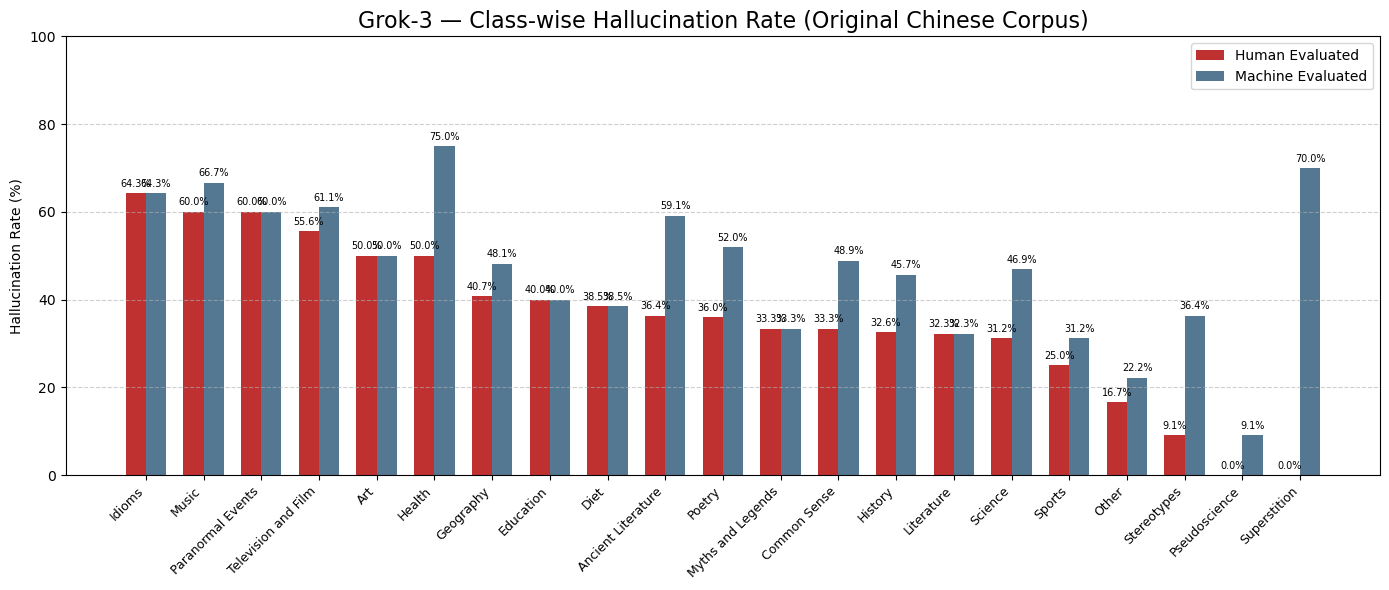

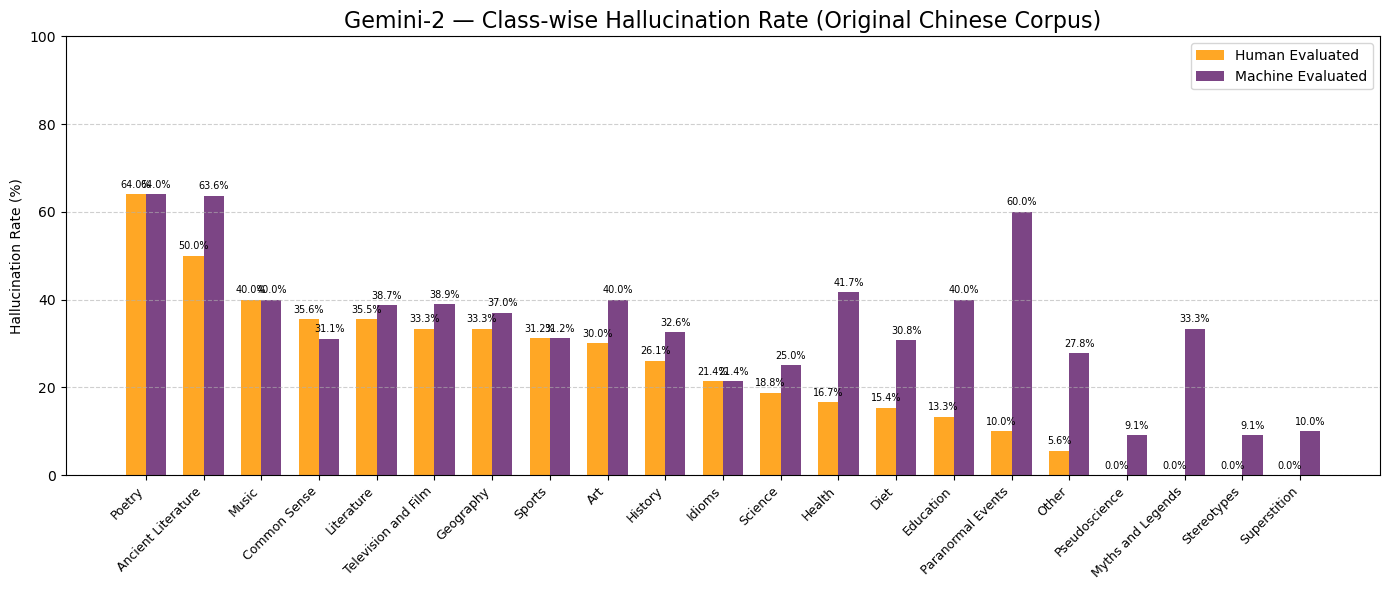

In [82]:
# Step 1: Helper function
def prepare_model_data_fixed(model_name, eval_type="human_evaluated"):
    records = []
    corpus = "original_chinese_corpus"  # Fix to Original Chinese only
    model_records = master_data[corpus][eval_type][model_name]
    for r in model_records:
        records.append({
            "Corpus": corpus,
            "Question ID": r["question_id"],
            "is_hallucination": r["is_hallucination"],
            "Class": id_to_class.get(r["question_id"], "Unknown")
        })
    df_model = pd.DataFrame(records)

    selected_classes = [
        "History", "Common Sense", "Science", "Literature", "Geography", "Poetry", 
        "Ancient Literature", "Television and Film", "Other", "Sports", "Music", 
        "Education", "Idioms", "Diet", "Myths and Legends", "Health", 
        "Pseudoscience", "Stereotypes", "Paranormal Events", "Art", "Superstition"
    ]
    df_model = df_model[df_model["Class"].isin(selected_classes)]

    class_rates = df_model.groupby("Class").apply(
        lambda x: (sum(x["is_hallucination"])/len(x)) * 100
    ).reset_index(name="Hallucination Rate (%)")

    return class_rates

# Step 2: Prepare data
gpt4o_human = prepare_model_data_fixed("gpt_4o", eval_type="human_evaluated")
gpt4o_machine = prepare_model_data_fixed("gpt_4o", eval_type="machine_evaluated")

grok3_human = prepare_model_data_fixed("grok_3", eval_type="human_evaluated")
grok3_machine = prepare_model_data_fixed("grok_3", eval_type="machine_evaluated")

gemini2_human = prepare_model_data_fixed("gemini_2", eval_type="human_evaluated")
gemini2_machine = prepare_model_data_fixed("gemini_2", eval_type="machine_evaluated")

# Step 3: Plotting function
def plot_human_machine_fixed(human_data, machine_data, model_name, human_color, machine_color):
    # Sort by Human hallucination rate
    human_data = human_data.sort_values("Hallucination Rate (%)", ascending=False)
    sorted_classes = human_data["Class"]

    # Match Machine data to sorted classes
    machine_data["Class"] = pd.Categorical(machine_data["Class"], categories=sorted_classes, ordered=True)
    machine_data = machine_data.sort_values("Class")

    x = np.arange(len(sorted_classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14,6))
    bars1 = ax.bar(x - width/2, human_data["Hallucination Rate (%)"], width=width, label="Human Evaluated", color=human_color)
    bars2 = ax.bar(x + width/2, machine_data["Hallucination Rate (%)"], width=width, label="Machine Evaluated", color=machine_color)

    ax.set_xticks(x)
    ax.set_xticklabels(sorted_classes, rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("Hallucination Rate (%)")
    ax.set_title(f"{model_name} — Class-wise Hallucination Rate (Original Chinese Corpus)", fontsize=16)
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend()

    # Annotate
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

    plt.tight_layout()
    plt.show()

# Step 4: Plot for each model
plot_human_machine_fixed(gpt4o_human, gpt4o_machine, "GPT-4o", human_color="#8AB2A6", machine_color="#E78B48")
plot_human_machine_fixed(grok3_human, grok3_machine, "Grok-3", human_color="#BF3131", machine_color="#547792")
plot_human_machine_fixed(gemini2_human, gemini2_machine, "Gemini-2", human_color="#FFA725", machine_color="#7C4585")


#### Human-translated

/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/2368693427.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_rates = df_model.groupby("Class").apply(
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/2368693427.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_rates = df_model.groupby("Class").apply(
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel

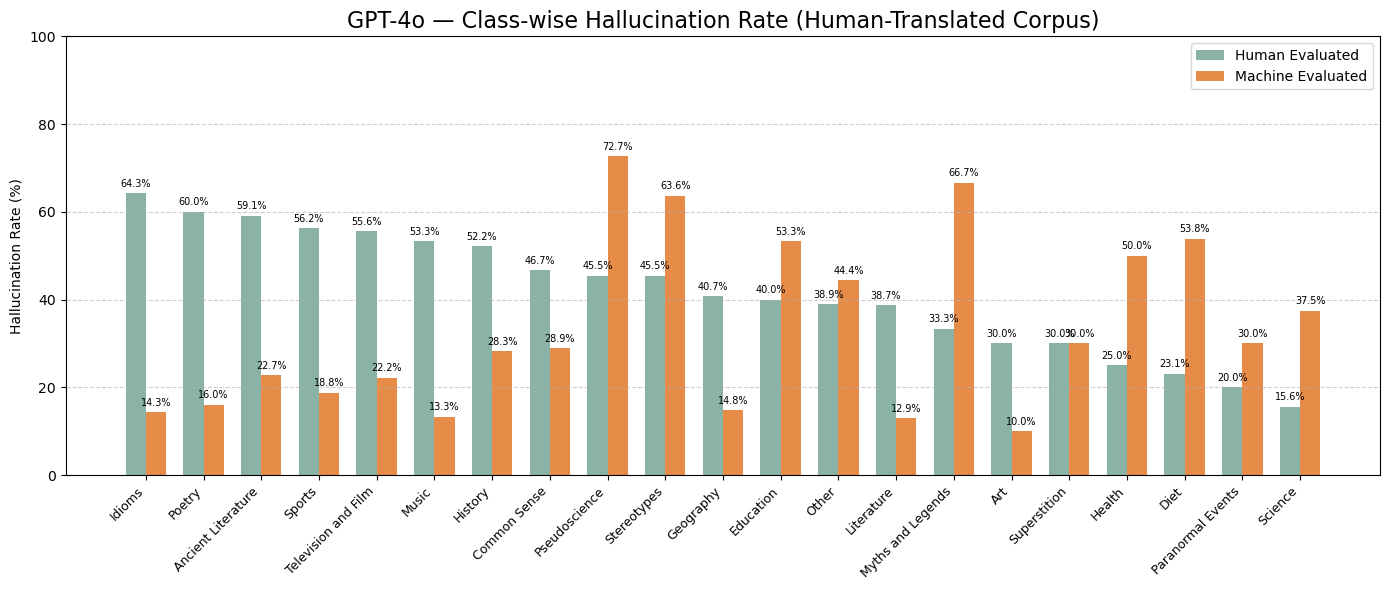

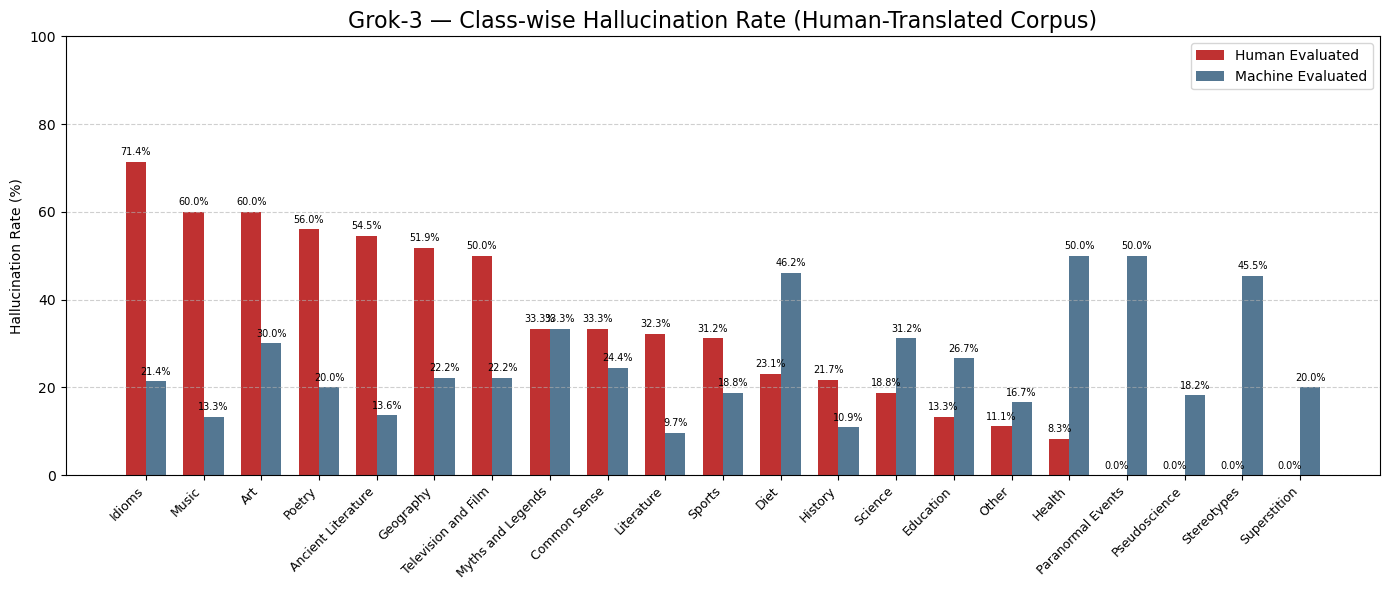

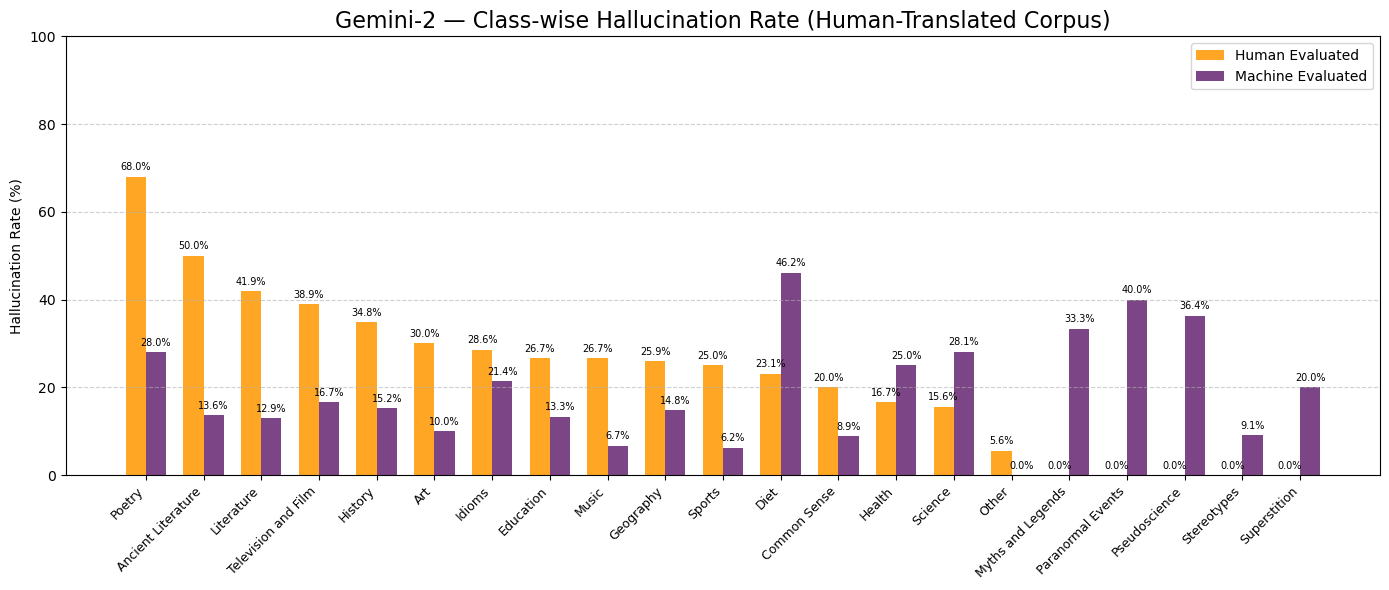

In [83]:

# Step 1: Helper function (target corpus is different now)
def prepare_model_data_fixed_human_translated(model_name, eval_type="human_evaluated"):
    records = []
    corpus = "human_translated_english_corpus"  # Now fix to Human Translated English
    model_records = master_data[corpus][eval_type][model_name]
    for r in model_records:
        records.append({
            "Corpus": corpus,
            "Question ID": r["question_id"],
            "is_hallucination": r["is_hallucination"],
            "Class": id_to_class.get(r["question_id"], "Unknown")
        })
    df_model = pd.DataFrame(records)

    selected_classes = [
        "History", "Common Sense", "Science", "Literature", "Geography", "Poetry", 
        "Ancient Literature", "Television and Film", "Other", "Sports", "Music", 
        "Education", "Idioms", "Diet", "Myths and Legends", "Health", 
        "Pseudoscience", "Stereotypes", "Paranormal Events", "Art", "Superstition"
    ]
    df_model = df_model[df_model["Class"].isin(selected_classes)]

    class_rates = df_model.groupby("Class").apply(
        lambda x: (sum(x["is_hallucination"])/len(x)) * 100
    ).reset_index(name="Hallucination Rate (%)")

    return class_rates

# Step 2: Prepare data
gpt4o_human_trans = prepare_model_data_fixed_human_translated("gpt_4o", eval_type="human_evaluated")
gpt4o_machine_trans = prepare_model_data_fixed_human_translated("gpt_4o", eval_type="machine_evaluated")

grok3_human_trans = prepare_model_data_fixed_human_translated("grok_3", eval_type="human_evaluated")
grok3_machine_trans = prepare_model_data_fixed_human_translated("grok_3", eval_type="machine_evaluated")

gemini2_human_trans = prepare_model_data_fixed_human_translated("gemini_2", eval_type="human_evaluated")
gemini2_machine_trans = prepare_model_data_fixed_human_translated("gemini_2", eval_type="machine_evaluated")

# Step 3: Plotting function (same as before)
def plot_human_machine_fixed(human_data, machine_data, model_name, human_color, machine_color):
    # Sort by Human hallucination rate
    human_data = human_data.sort_values("Hallucination Rate (%)", ascending=False)
    sorted_classes = human_data["Class"]

    # Match Machine data to sorted classes
    machine_data["Class"] = pd.Categorical(machine_data["Class"], categories=sorted_classes, ordered=True)
    machine_data = machine_data.sort_values("Class")

    x = np.arange(len(sorted_classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14,6))
    bars1 = ax.bar(x - width/2, human_data["Hallucination Rate (%)"], width=width, label="Human Evaluated", color=human_color)
    bars2 = ax.bar(x + width/2, machine_data["Hallucination Rate (%)"], width=width, label="Machine Evaluated", color=machine_color)

    ax.set_xticks(x)
    ax.set_xticklabels(sorted_classes, rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("Hallucination Rate (%)")
    ax.set_title(f"{model_name} — Class-wise Hallucination Rate (Human-Translated Corpus)", fontsize=16)
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend()

    # Annotate
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

    plt.tight_layout()
    plt.show()

# Step 4: Plot for each model
plot_human_machine_fixed(gpt4o_human_trans, gpt4o_machine_trans, "GPT-4o", human_color="#8AB2A6", machine_color="#E78B48")
plot_human_machine_fixed(grok3_human_trans, grok3_machine_trans, "Grok-3", human_color="#BF3131", machine_color="#547792")
plot_human_machine_fixed(gemini2_human_trans, gemini2_machine_trans, "Gemini-2", human_color="#FFA725", machine_color="#7C4585")


#### Machine translated

/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/1489711004.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_rates = df_model.groupby("Class").apply(
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/1489711004.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_rates = df_model.groupby("Class").apply(
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel

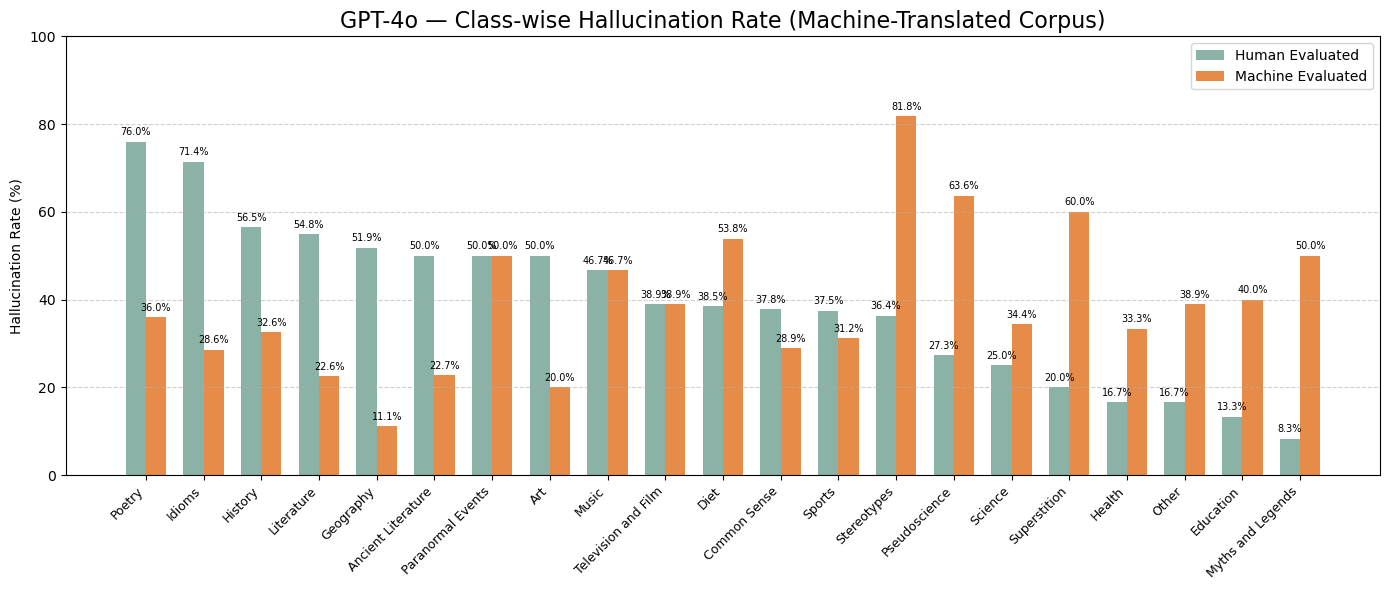

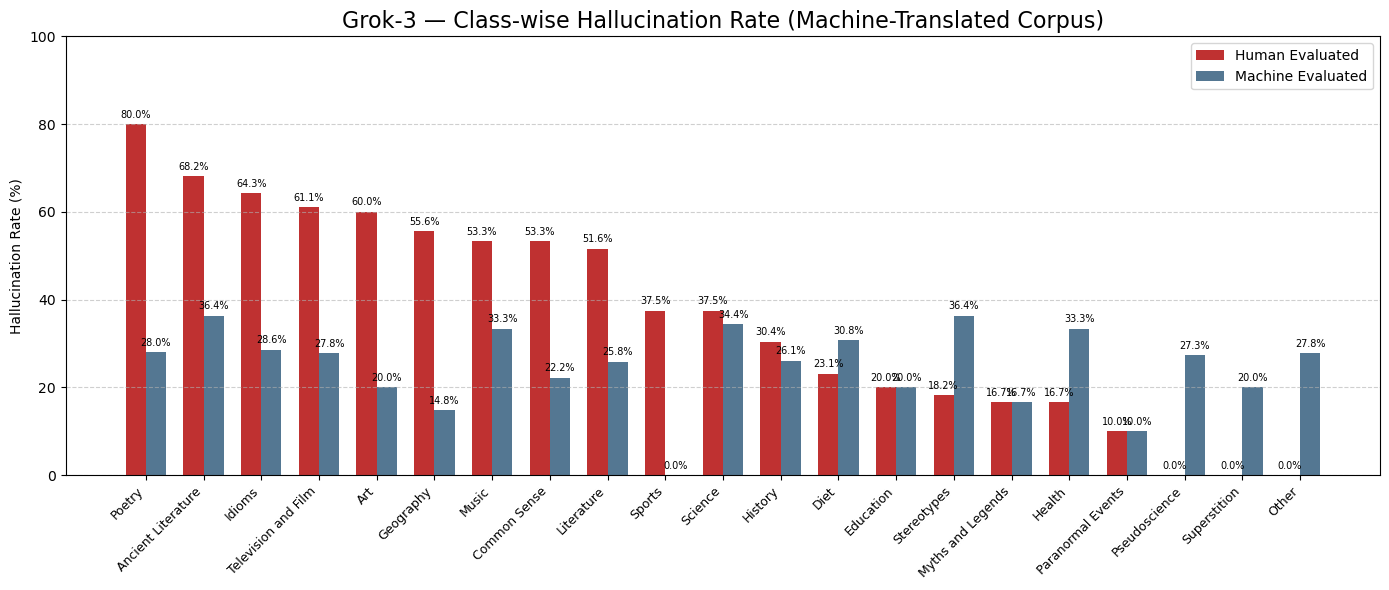

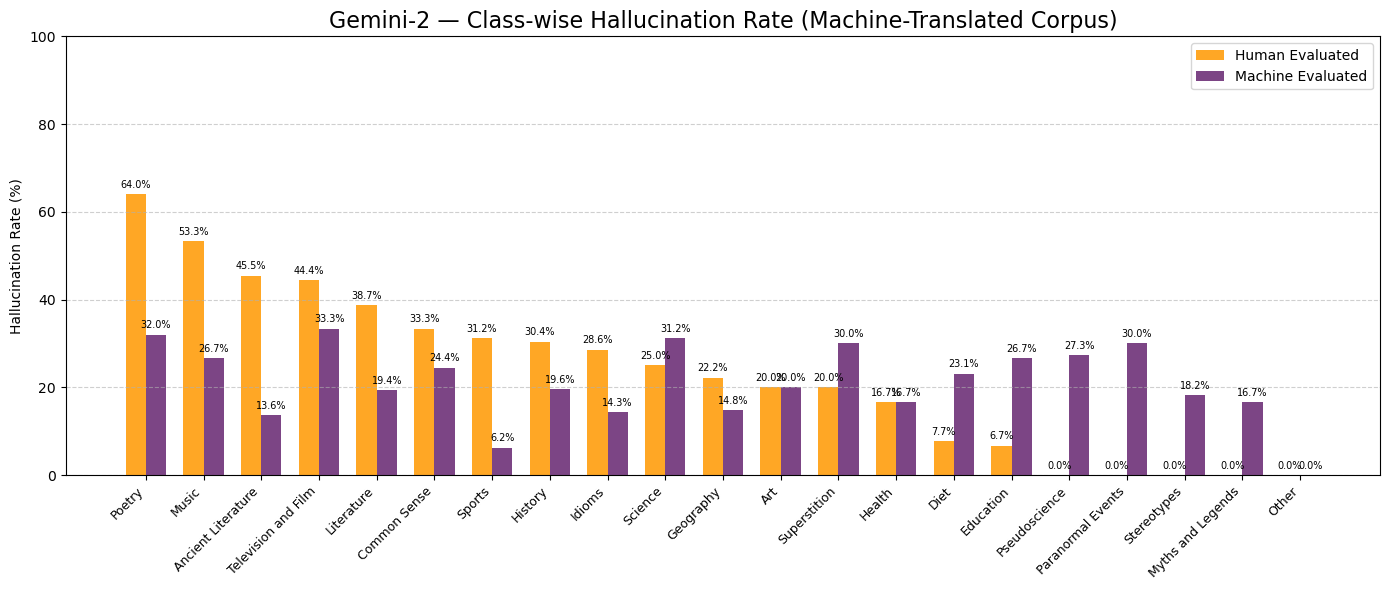

In [84]:
# Step 1: Helper function (target corpus now machine-translated)
def prepare_model_data_fixed_machine_translated(model_name, eval_type="human_evaluated"):
    records = []
    corpus = "machine_translated_english_corpus"  # Now fix to Machine-Translated English
    model_records = master_data[corpus][eval_type][model_name]
    for r in model_records:
        records.append({
            "Corpus": corpus,
            "Question ID": r["question_id"],
            "is_hallucination": r["is_hallucination"],
            "Class": id_to_class.get(r["question_id"], "Unknown")
        })
    df_model = pd.DataFrame(records)

    selected_classes = [
        "History", "Common Sense", "Science", "Literature", "Geography", "Poetry", 
        "Ancient Literature", "Television and Film", "Other", "Sports", "Music", 
        "Education", "Idioms", "Diet", "Myths and Legends", "Health", 
        "Pseudoscience", "Stereotypes", "Paranormal Events", "Art", "Superstition"
    ]
    df_model = df_model[df_model["Class"].isin(selected_classes)]

    class_rates = df_model.groupby("Class").apply(
        lambda x: (sum(x["is_hallucination"])/len(x)) * 100
    ).reset_index(name="Hallucination Rate (%)")

    return class_rates

# Step 2: Prepare data
gpt4o_human_mt = prepare_model_data_fixed_machine_translated("gpt_4o", eval_type="human_evaluated")
gpt4o_machine_mt = prepare_model_data_fixed_machine_translated("gpt_4o", eval_type="machine_evaluated")

grok3_human_mt = prepare_model_data_fixed_machine_translated("grok_3", eval_type="human_evaluated")
grok3_machine_mt = prepare_model_data_fixed_machine_translated("grok_3", eval_type="machine_evaluated")

gemini2_human_mt = prepare_model_data_fixed_machine_translated("gemini_2", eval_type="human_evaluated")
gemini2_machine_mt = prepare_model_data_fixed_machine_translated("gemini_2", eval_type="machine_evaluated")

# Step 3: Plotting function (same as before)
def plot_human_machine_fixed(human_data, machine_data, model_name, human_color, machine_color):
    # Sort by Human hallucination rate
    human_data = human_data.sort_values("Hallucination Rate (%)", ascending=False)
    sorted_classes = human_data["Class"]

    # Match Machine data to sorted classes
    machine_data["Class"] = pd.Categorical(machine_data["Class"], categories=sorted_classes, ordered=True)
    machine_data = machine_data.sort_values("Class")

    x = np.arange(len(sorted_classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14,6))
    bars1 = ax.bar(x - width/2, human_data["Hallucination Rate (%)"], width=width, label="Human Evaluated", color=human_color)
    bars2 = ax.bar(x + width/2, machine_data["Hallucination Rate (%)"], width=width, label="Machine Evaluated", color=machine_color)

    ax.set_xticks(x)
    ax.set_xticklabels(sorted_classes, rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("Hallucination Rate (%)")
    ax.set_title(f"{model_name} — Class-wise Hallucination Rate (Machine-Translated Corpus)", fontsize=16)
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend()

    # Annotate
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=7)

    plt.tight_layout()
    plt.show()

# Step 4: Plot for each model
plot_human_machine_fixed(gpt4o_human_mt, gpt4o_machine_mt, "GPT-4o", human_color="#8AB2A6", machine_color="#E78B48")
plot_human_machine_fixed(grok3_human_mt, grok3_machine_mt, "Grok-3", human_color="#BF3131", machine_color="#547792")
plot_human_machine_fixed(gemini2_human_mt, gemini2_machine_mt, "Gemini-2", human_color="#FFA725", machine_color="#7C4585")


### See how translation impact the performance

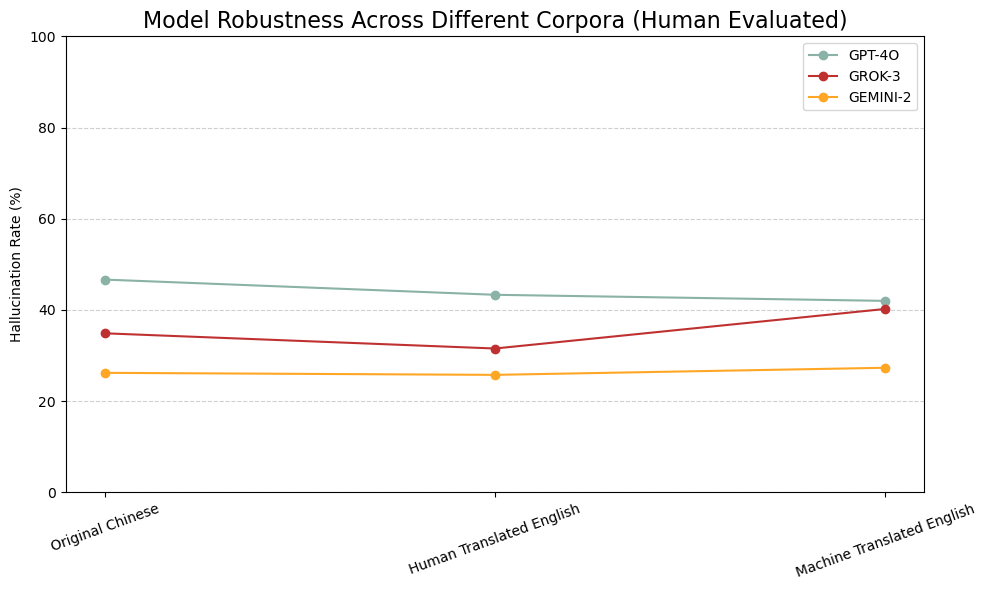

In [85]:
# Step 1: Helper to calculate overall hallucination rate for each model + corpus
def calculate_model_corpus_hallucination(model_name, eval_type="human_evaluated"):
    records = []
    for corpus in master_data:
        model_records = master_data[corpus][eval_type][model_name]
        hallucination_flags = [r["is_hallucination"] for r in model_records]
        hallucination_rate = (sum(hallucination_flags) / len(hallucination_flags)) * 100
        records.append({
            "Model": model_name,
            "Corpus": corpus,
            "Hallucination Rate (%)": hallucination_rate
        })
    return pd.DataFrame(records)

# Step 2: Prepare Human Evaluated data
gpt4o_human_corpus = calculate_model_corpus_hallucination("gpt_4o", eval_type="human_evaluated")
grok3_human_corpus = calculate_model_corpus_hallucination("grok_3", eval_type="human_evaluated")
gemini2_human_corpus = calculate_model_corpus_hallucination("gemini_2", eval_type="human_evaluated")

# Step 3: Merge all
df_human_corpus = pd.concat([gpt4o_human_corpus, grok3_human_corpus, gemini2_human_corpus])

# Step 4: Clean corpus names
corpus_mapping = {
    "original_chinese_corpus": "Original Chinese",
    "human_translated_english_corpus": "Human Translated English",
    "machine_translated_english_corpus": "Machine Translated English"
}
df_human_corpus["Corpus"] = df_human_corpus["Corpus"].map(corpus_mapping)

# Step 5: Plot
plt.figure(figsize=(10,6))

model_colors = {
    "gpt_4o": "#8AB2A6",
    "grok_3": "#BF3131",
    "gemini_2": "#FFA725"
}

for model in ["gpt_4o", "grok_3", "gemini_2"]:
    subset = df_human_corpus[df_human_corpus["Model"] == model]
    plt.plot(subset["Corpus"], subset["Hallucination Rate (%)"], marker="o", label=model.replace("_", "-").upper(), color=model_colors[model])

plt.xticks(rotation=20)
plt.ylim(0, 100)
plt.ylabel("Hallucination Rate (%)")
plt.title("Model Robustness Across Different Corpora (Human Evaluated)", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


### Translation affect performance

/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/3824716899.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_rates = df_model.groupby(["Corpus", "Class"]).apply(
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/3824716899.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_rates = df_model.groupby(["Corpus", "Class"]).apply(
/var/folders/30/7fk6fkmd2fvb8lfb3m

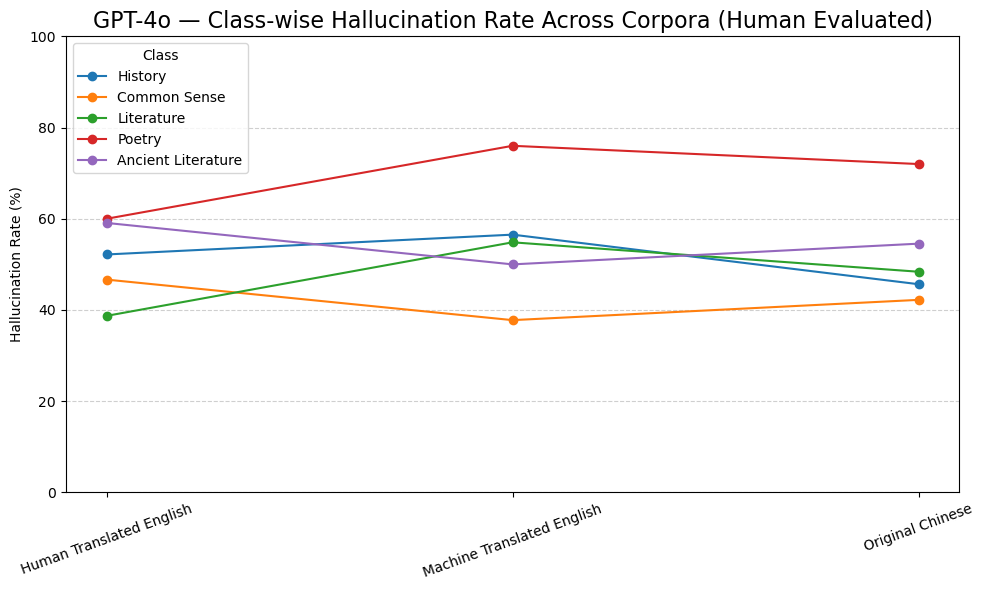

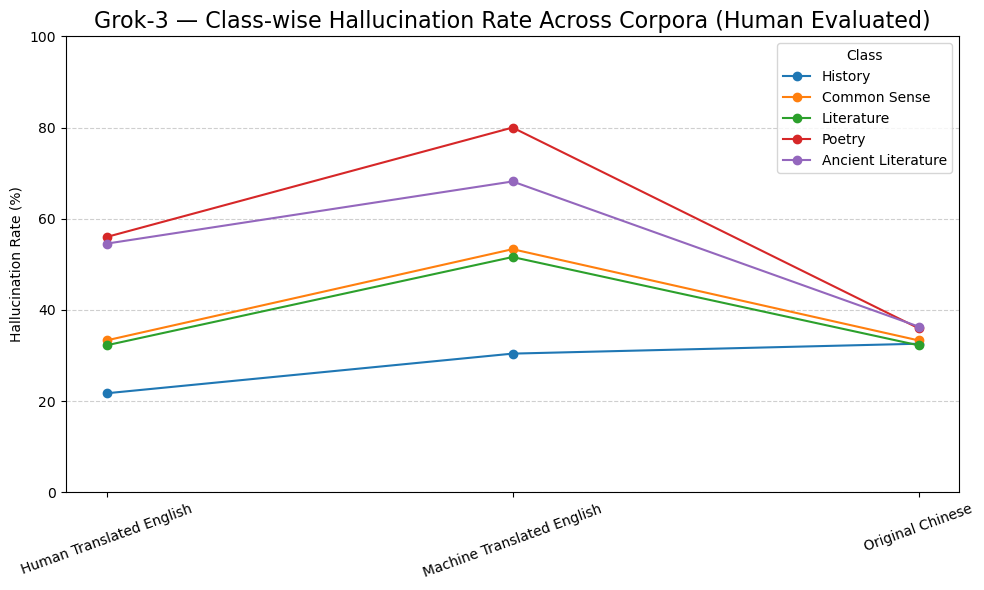

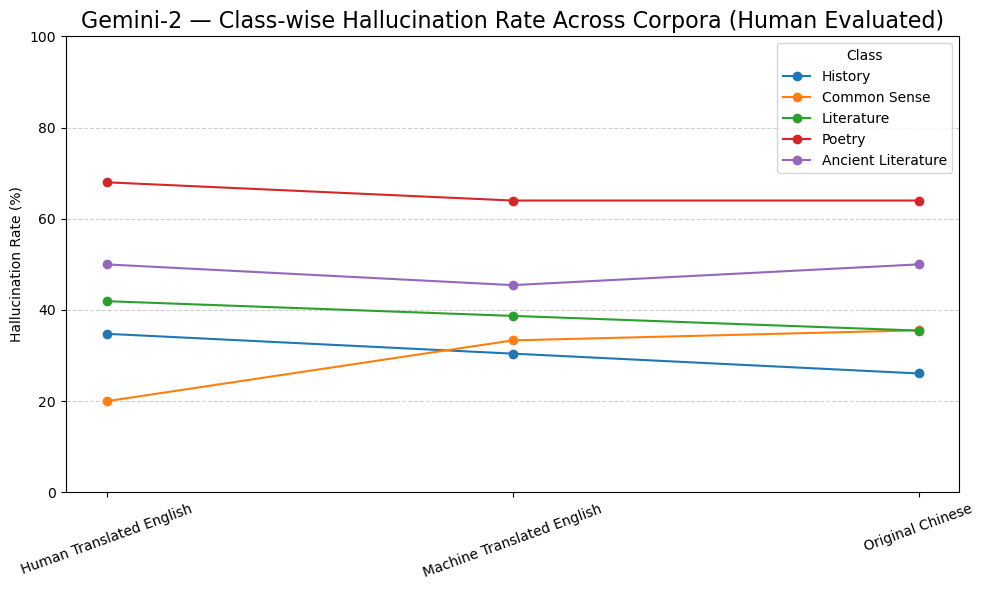

In [86]:
# Step 1: Helper function — calculate hallucination rate per class, per corpus, per model
def calculate_class_corpus_hallucination(model_name, target_classes, eval_type="human_evaluated"):
    records = []
    for corpus in ["original_chinese_corpus", "human_translated_english_corpus", "machine_translated_english_corpus"]:
        model_records = master_data[corpus][eval_type][model_name]
        for r in model_records:
            class_label = id_to_class.get(r["question_id"], "Unknown")
            if class_label in target_classes:
                records.append({
                    "Corpus": corpus,
                    "Class": class_label,
                    "is_hallucination": r["is_hallucination"]
                })
    df_model = pd.DataFrame(records)

    # Group by Corpus + Class
    class_rates = df_model.groupby(["Corpus", "Class"]).apply(
        lambda x: (sum(x["is_hallucination"]) / len(x)) * 100
    ).reset_index(name="Hallucination Rate (%)")

    return class_rates

# Step 2: Target classes you picked
target_classes = [
    "History", "Common Sense", "Literature", "Poetry", "Ancient Literature"
]

# Step 3: Prepare data
gpt4o_class_corpus = calculate_class_corpus_hallucination("gpt_4o", target_classes, eval_type="human_evaluated")
grok3_class_corpus = calculate_class_corpus_hallucination("grok_3", target_classes, eval_type="human_evaluated")
gemini2_class_corpus = calculate_class_corpus_hallucination("gemini_2", target_classes, eval_type="human_evaluated")

# Step 4: Clean corpus names
corpus_mapping = {
    "original_chinese_corpus": "Original Chinese",
    "human_translated_english_corpus": "Human Translated English",
    "machine_translated_english_corpus": "Machine Translated English"
}
for df in [gpt4o_class_corpus, grok3_class_corpus, gemini2_class_corpus]:
    df["Corpus"] = df["Corpus"].map(corpus_mapping)

# Step 5: Plotting function
def plot_class_translation_sensitivity(df_class_corpus, model_name, color):
    plt.figure(figsize=(10,6))

    for cls in target_classes:
        subset = df_class_corpus[df_class_corpus["Class"] == cls]
        plt.plot(subset["Corpus"], subset["Hallucination Rate (%)"], marker="o", label=cls)

    plt.xticks(rotation=20)
    plt.ylim(0, 100)
    plt.ylabel("Hallucination Rate (%)")
    plt.title(f"{model_name} — Class-wise Hallucination Rate Across Corpora (Human Evaluated)", fontsize=16)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend(title="Class")
    plt.tight_layout()
    plt.show()

# Step 6: Plot per model
plot_class_translation_sensitivity(gpt4o_class_corpus, "GPT-4o", color="#8AB2A6")
plot_class_translation_sensitivity(grok3_class_corpus, "Grok-3", color="#BF3131")
plot_class_translation_sensitivity(gemini2_class_corpus, "Gemini-2", color="#FFA725")


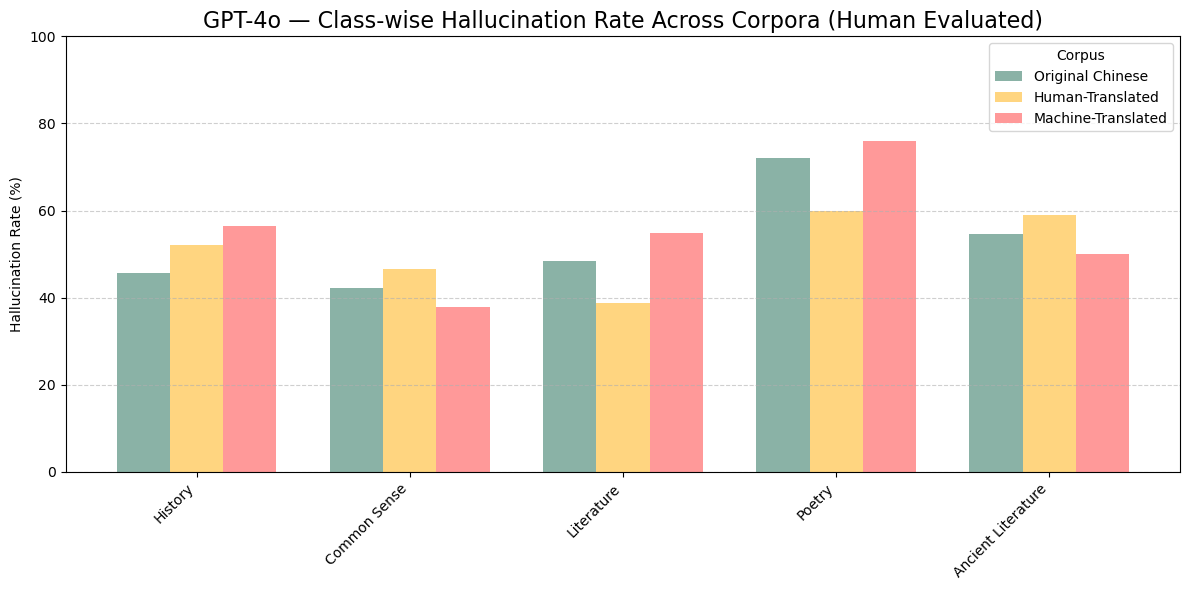

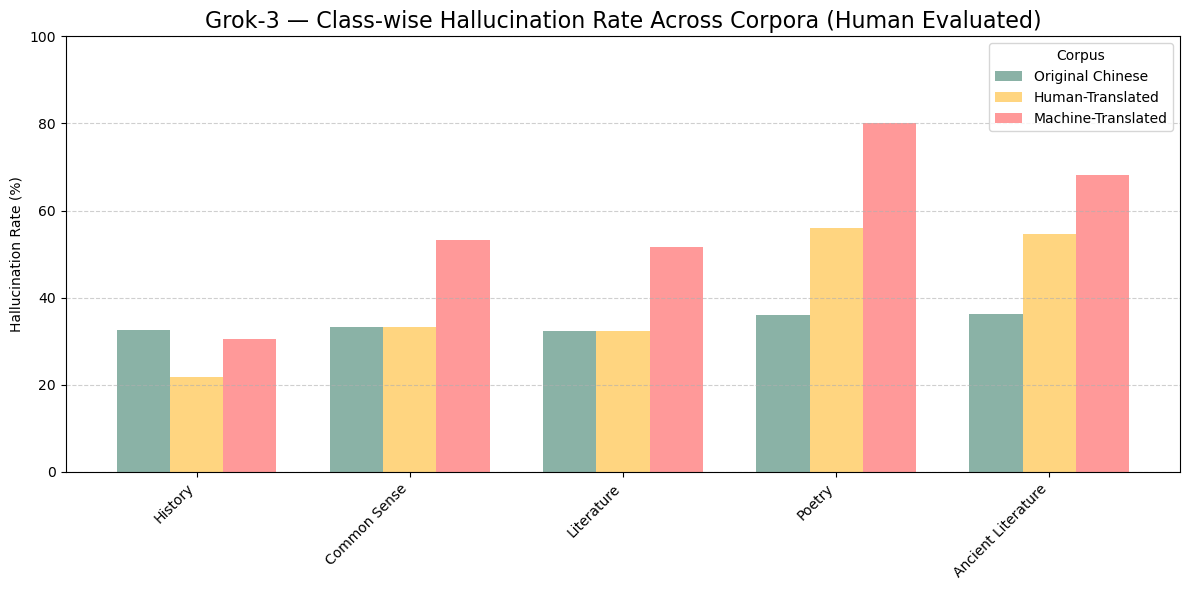

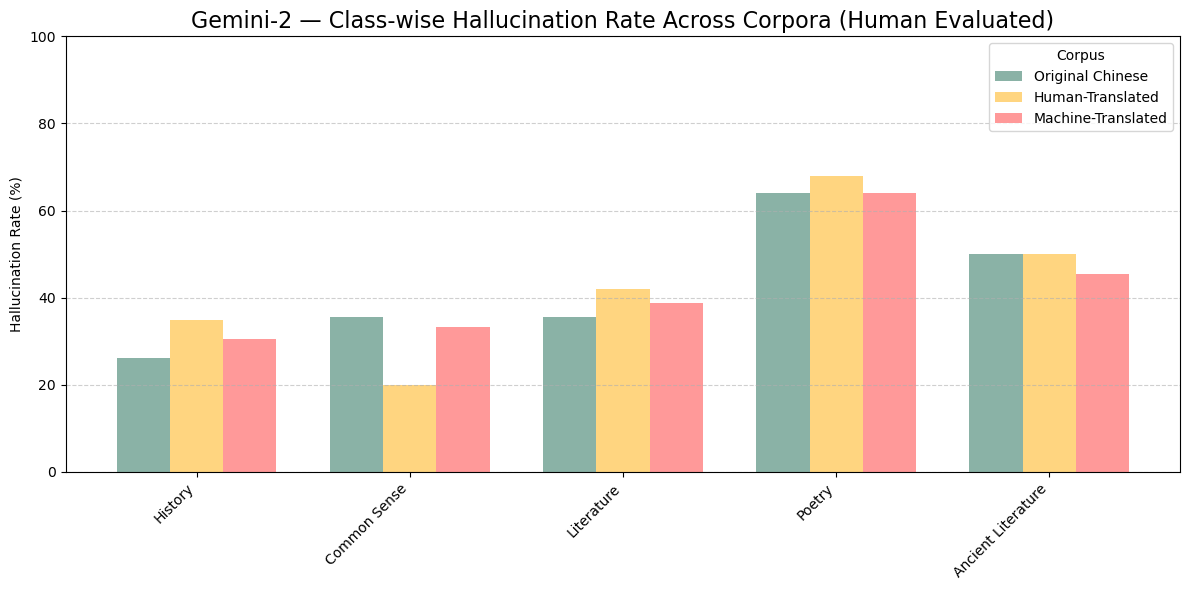

In [87]:
# Step 1: Reuse previous preparation
# (we already have gpt4o_class_corpus, grok3_class_corpus, gemini2_class_corpus from earlier)

# Step 2: Corpus pretty names
corpus_pretty = {
    "Original Chinese": "Original Chinese",
    "Human Translated English": "Human-Translated",
    "Machine Translated English": "Machine-Translated"
}

# Step 3: Plotting function
def plot_class_bar_by_corpus(df_class_corpus, model_name, colors):
    classes_order = [
        "History", "Common Sense", "Literature", "Poetry", "Ancient Literature"
    ]

    # Prepare plot
    x = np.arange(len(classes_order))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12,6))

    # Bars per corpus
    for idx, corpus in enumerate(["Original Chinese", "Human Translated English", "Machine Translated English"]):
        subset = df_class_corpus[df_class_corpus["Corpus"] == corpus]
        subset = subset.set_index("Class").reindex(classes_order)
        ax.bar(x + idx*width - width, subset["Hallucination Rate (%)"], width=width, label=corpus_pretty[corpus], color=colors[idx])

    ax.set_xticks(x)
    ax.set_xticklabels(classes_order, rotation=45, ha="right", fontsize=10)
    ax.set_ylabel("Hallucination Rate (%)")
    ax.set_ylim(0, 100)
    ax.set_title(f"{model_name} — Class-wise Hallucination Rate Across Corpora (Human Evaluated)", fontsize=16)
    ax.legend(title="Corpus")
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Step 4: Define colors (soft pastel)
colors_soft = ["#8AB2A6", "#FFD580", "#FF9999"]  # Calm green, soft yellow, soft red

# Step 5: Plot for each model
plot_class_bar_by_corpus(gpt4o_class_corpus, "GPT-4o", colors_soft)
plot_class_bar_by_corpus(grok3_class_corpus, "Grok-3", colors_soft)
plot_class_bar_by_corpus(gemini2_class_corpus, "Gemini-2", colors_soft)


In [88]:
# Step 1: Target classes
target_classes = ["History", "Common Sense", "Literature", "Poetry", "Ancient Literature"]

# Step 2: Helper to extract per model
def extract_hallucination_with_sample_size(model_name):
    results = []
    for corpus in ["original_chinese_corpus", "human_translated_english_corpus", "machine_translated_english_corpus"]:
        model_records = master_data[corpus]["human_evaluated"][model_name]
        for r in model_records:
            class_label = id_to_class.get(r["question_id"], "Unknown")
            if class_label in target_classes:
                results.append({
                    "Corpus": corpus,
                    "Class": class_label,
                    "is_hallucination": r["is_hallucination"]
                })
    df = pd.DataFrame(results)

    # Pretty corpus names
    df["Corpus"] = df["Corpus"].replace({
        "original_chinese_corpus": "Original Chinese",
        "human_translated_english_corpus": "Human Translated",
        "machine_translated_english_corpus": "Machine Translated"
    })
    return df

# Step 3: Process per model
def build_summary_table(model_name):
    df = extract_hallucination_with_sample_size(model_name)

    summary = []
    for cls in target_classes:
        cls_data = df[df["Class"] == cls]
        sample_size = len(cls_data[df["Corpus"] == "Original Chinese"])
        oc_rate = cls_data[cls_data["Corpus"] == "Original Chinese"]["is_hallucination"].mean() * 100
        ht_rate = cls_data[cls_data["Corpus"] == "Human Translated"]["is_hallucination"].mean() * 100
        mt_rate = cls_data[cls_data["Corpus"] == "Machine Translated"]["is_hallucination"].mean() * 100

        summary.append({
            "Class": cls,
            "Sample Size (OC)": sample_size,
            "OC Hallucination (%)": round(oc_rate, 2),
            "HTE Hallucination (%)": round(ht_rate, 2),
            "MTE Hallucination (%)": round(mt_rate, 2)
        })

    return pd.DataFrame(summary)

# Step 4: Build for each model
gpt4o_summary = build_summary_table("gpt_4o")
grok3_summary = build_summary_table("grok_3")
gemini2_summary = build_summary_table("gemini_2")

# Step 5: Show GPT-4o first
gpt4o_summary


/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/326797948.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_size = len(cls_data[df["Corpus"] == "Original Chinese"])
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/326797948.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_size = len(cls_data[df["Corpus"] == "Original Chinese"])
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/326797948.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_size = len(cls_data[df["Corpus"] == "Original Chinese"])
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/326797948.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_size = len(cls_data[df["Corpus"] == "Original Chinese"])
/var/folders/30/7fk6fkmd2fvb8lfb3m2386g40000gn/T/ipykernel_56717/326797948.py:34: UserWarning: Boolean S

,Class,Sample Size (OC),OC Hallucination (%),HTE Hallucination (%),MTE Hallucination (%)
0,History,46,45.65,52.17,56.52
1,Common Sense,45,42.22,46.67,37.78
2,Literature,31,48.39,38.71,54.84
3,Poetry,25,72.00,60.00,76.00
4,Ancient Literature,22,54.55,59.09,50.00


### Permutation test

#### gpt: class

In [105]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Step 1: Prepare real data
target_classes = ["History", "Common Sense", "Literature", "Poetry", "Ancient Literature"]

def gather_gpt4o_one_corpus(target_corpus):
    records = []
    model_records = master_data[target_corpus]["human_evaluated"]["gpt_4o"]
    for r in model_records:
        class_label = id_to_class.get(r["question_id"], "Unknown")
        if class_label in target_classes:
            records.append({
                "Class": class_label,
                "is_hallucination": r["is_hallucination"]
            })
    df = pd.DataFrame(records)
    return df

# Pick one corpus (example: "original_chinese_corpus")
df_real_class = gather_gpt4o_one_corpus("original_chinese_corpus")

# Step 2: Calculate REAL variance in hallucination rates across Class
def calc_class_variance(df):
    rate_by_class = df.groupby("Class")["is_hallucination"].mean()
    variance = np.var(rate_by_class)
    return variance

real_class_variance = calc_class_variance(df_real_class)

print(f"Real Variance in Hallucination Rates (by Class, One Corpus): {real_class_variance:.4f}")

# Step 3: Permutation Test
num_permutations = 10000
fake_variances_class = []

for _ in tqdm(range(num_permutations)):
    df_shuffled = df_real_class.copy()
    df_shuffled["Class"] = np.random.permutation(df_shuffled["Class"])
    fake_var = calc_class_variance(df_shuffled)
    fake_variances_class.append(fake_var)

# Step 4: Calculate p-value
fake_variances_class = np.array(fake_variances_class)
p_value_class = np.mean(fake_variances_class >= real_class_variance)

print("\nPermutation Test Results (Class, One Corpus):")
print(f"Observed Variance: {real_class_variance:.4f}")
print(f"Mean Null Variance: {np.mean(fake_variances_class):.4f}")
print(f"P-Value: {p_value_class:.4f}")

if p_value_class < 0.05:
    print("❗️Reject Null Hypothesis: Hallucination rate depends on Class.")
else:
    print("✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.")


Real Variance in Hallucination Rates (by Class, One Corpus): 0.0111


100%|██████████| 10000/10000 [00:01<00:00, 7034.24it/s]


Permutation Test Results (Class, One Corpus):
Observed Variance: 0.0111
Mean Null Variance: 0.0065
P-Value: 0.1477
✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.


In [106]:
# Step 1: Prepare real data
target_classes = ["History", "Common Sense", "Literature", "Poetry", "Ancient Literature"]

def gather_gpt4o_one_corpus(target_corpus):
    records = []
    model_records = master_data[target_corpus]["human_evaluated"]["gpt_4o"]
    for r in model_records:
        class_label = id_to_class.get(r["question_id"], "Unknown")
        if class_label in target_classes:
            records.append({
                "Class": class_label,
                "is_hallucination": r["is_hallucination"]
            })
    df = pd.DataFrame(records)
    return df

# Pick one corpus (example: "original_chinese_corpus")
df_real_class = gather_gpt4o_one_corpus("human_translated_english_corpus")

# Step 2: Calculate REAL variance in hallucination rates across Class
def calc_class_variance(df):
    rate_by_class = df.groupby("Class")["is_hallucination"].mean()
    variance = np.var(rate_by_class)
    return variance

real_class_variance = calc_class_variance(df_real_class)

print(f"Real Variance in Hallucination Rates (by Class, One Corpus): {real_class_variance:.4f}")

# Step 3: Permutation Test
num_permutations = 10000
fake_variances_class = []

for _ in tqdm(range(num_permutations)):
    df_shuffled = df_real_class.copy()
    df_shuffled["Class"] = np.random.permutation(df_shuffled["Class"])
    fake_var = calc_class_variance(df_shuffled)
    fake_variances_class.append(fake_var)

# Step 4: Calculate p-value
fake_variances_class = np.array(fake_variances_class)
p_value_class = np.mean(fake_variances_class >= real_class_variance)

print("\nPermutation Test Results (Class, One Corpus):")
print(f"Observed Variance: {real_class_variance:.4f}")
print(f"Mean Null Variance: {np.mean(fake_variances_class):.4f}")
print(f"P-Value: {p_value_class:.4f}")

if p_value_class < 0.05:
    print("❗️Reject Null Hypothesis: Hallucination rate depends on Class.")
else:
    print("✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.")


Real Variance in Hallucination Rates (by Class, One Corpus): 0.0063


100%|██████████| 10000/10000 [00:01<00:00, 6918.28it/s]


Permutation Test Results (Class, One Corpus):
Observed Variance: 0.0063
Mean Null Variance: 0.0066
P-Value: 0.4191
✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.


In [110]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Step 1: Prepare real data
target_classes = ["History", "Common Sense", "Literature", "Poetry", "Ancient Literature"]

def gather_gpt4o_one_corpus(target_corpus):
    records = []
    model_records = master_data[target_corpus]["human_evaluated"]["gpt_4o"]
    for r in model_records:
        class_label = id_to_class.get(r["question_id"], "Unknown")
        if class_label in target_classes:
            records.append({
                "Class": class_label,
                "is_hallucination": r["is_hallucination"]
            })
    df = pd.DataFrame(records)
    return df

# Pick one corpus (example: "original_chinese_corpus")
df_real_class = gather_gpt4o_one_corpus("machine_translated_english_corpus")

# Step 2: Calculate REAL variance in hallucination rates across Class
def calc_class_variance(df):
    rate_by_class = df.groupby("Class")["is_hallucination"].mean()
    variance = np.var(rate_by_class)
    return variance

real_class_variance = calc_class_variance(df_real_class)

print(f"Real Variance in Hallucination Rates (by Class, One Corpus): {real_class_variance:.4f}")

# Step 3: Permutation Test
num_permutations = 10000
fake_variances_class = []

for _ in tqdm(range(num_permutations)):
    df_shuffled = df_real_class.copy()
    df_shuffled["Class"] = np.random.permutation(df_shuffled["Class"])
    fake_var = calc_class_variance(df_shuffled)
    fake_variances_class.append(fake_var)

# Step 4: Calculate p-value
fake_variances_class = np.array(fake_variances_class)
p_value_class = np.mean(fake_variances_class >= real_class_variance)

print("\nPermutation Test Results (Class, One Corpus):")
print(f"Observed Variance: {real_class_variance:.4f}")
print(f"Mean Null Variance: {np.mean(fake_variances_class):.4f}")
print(f"P-Value: {p_value_class:.4f}")

if p_value_class < 0.05:
    print("❗️Reject Null Hypothesis: Hallucination rate depends on Class.")
else:
    print("✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.")


Real Variance in Hallucination Rates (by Class, One Corpus): 0.0153


100%|██████████| 10000/10000 [00:01<00:00, 7040.56it/s]


Permutation Test Results (Class, One Corpus):
Observed Variance: 0.0153
Mean Null Variance: 0.0066
P-Value: 0.0582
✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.


#### gemini: class

In [115]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Step 1: Prepare real data
target_classes = ["History", "Common Sense", "Literature", "Poetry", "Ancient Literature"]

def gather_gemini_data_one_corpus(target_corpus):
    records = []
    model_records = master_data[target_corpus]["human_evaluated"]["gemini_2"]
    for r in model_records:
        class_label = id_to_class.get(r["question_id"], "Unknown")
        if class_label in target_classes:
            records.append({
                "Class": class_label,
                "is_hallucination": r["is_hallucination"]
            })
    df = pd.DataFrame(records)
    return df

def run_permutation_test(df_real_class, num_permutations=10000):
    def calc_class_variance(df):
        rate_by_class = df.groupby("Class")["is_hallucination"].mean()
        variance = np.var(rate_by_class)
        return variance

    real_class_variance = calc_class_variance(df_real_class)

    fake_variances_class = []
    for _ in tqdm(range(num_permutations)):
        df_shuffled = df_real_class.copy()
        df_shuffled["Class"] = np.random.permutation(df_shuffled["Class"])
        fake_var = calc_class_variance(df_shuffled)
        fake_variances_class.append(fake_var)

    fake_variances_class = np.array(fake_variances_class)
    p_value_class = np.mean(fake_variances_class >= real_class_variance)

    print("\nPermutation Test Results (Gemini-2, One Corpus):")
    print(f"Observed Variance: {real_class_variance:.4f}")
    print(f"Mean Null Variance: {np.mean(fake_variances_class):.4f}")
    print(f"P-Value: {p_value_class:.4f}")

    if p_value_class < 0.05:
        print("❗️Reject Null Hypothesis: Hallucination rate depends on Class.")
    else:
        print("✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.")

# Step 2: Run for each corpus

# --- Original Chinese Corpus ---
print("=== Gemini-2: Original Chinese Corpus ===")
df_gemini_oc = gather_gemini_data_one_corpus("original_chinese_corpus")
run_permutation_test(df_gemini_oc)

# --- Human-Translated English Corpus ---
print("\n=== Gemini-2: Human Translated English Corpus ===")
df_gemini_hte = gather_gemini_data_one_corpus("human_translated_english_corpus")
run_permutation_test(df_gemini_hte)

# --- Machine-Translated English Corpus ---
print("\n=== Gemini-2: Machine Translated English Corpus ===")
df_gemini_mte = gather_gemini_data_one_corpus("machine_translated_english_corpus")
run_permutation_test(df_gemini_mte)

=== Gemini-2: Original Chinese Corpus ===


100%|██████████| 10000/10000 [00:01<00:00, 6979.66it/s]



Permutation Test Results (Gemini-2, One Corpus):
Observed Variance: 0.0177
Mean Null Variance: 0.0062
P-Value: 0.0244
❗️Reject Null Hypothesis: Hallucination rate depends on Class.

=== Gemini-2: Human Translated English Corpus ===


100%|██████████| 10000/10000 [00:01<00:00, 7137.73it/s]



Permutation Test Results (Gemini-2, One Corpus):
Observed Variance: 0.0254
Mean Null Variance: 0.0063
P-Value: 0.0035
❗️Reject Null Hypothesis: Hallucination rate depends on Class.

=== Gemini-2: Machine Translated English Corpus ===


100%|██████████| 10000/10000 [00:01<00:00, 7107.85it/s]


Permutation Test Results (Gemini-2, One Corpus):
Observed Variance: 0.0143
Mean Null Variance: 0.0063
P-Value: 0.0610
✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.


In [114]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Step 1: Prepare real data
target_classes = ["History", "Common Sense", "Literature", "Poetry", "Ancient Literature"]

def gather_grok_data_one_corpus(target_corpus):
    records = []
    model_records = master_data[target_corpus]["human_evaluated"]["grok_3"]
    for r in model_records:
        class_label = id_to_class.get(r["question_id"], "Unknown")
        if class_label in target_classes:
            records.append({
                "Class": class_label,
                "is_hallucination": r["is_hallucination"]
            })
    df = pd.DataFrame(records)
    return df

def run_permutation_test(df_real_class, num_permutations=10000):
    def calc_class_variance(df):
        rate_by_class = df.groupby("Class")["is_hallucination"].mean()
        variance = np.var(rate_by_class)
        return variance

    real_class_variance = calc_class_variance(df_real_class)

    fake_variances_class = []
    for _ in tqdm(range(num_permutations)):
        df_shuffled = df_real_class.copy()
        df_shuffled["Class"] = np.random.permutation(df_shuffled["Class"])
        fake_var = calc_class_variance(df_shuffled)
        fake_variances_class.append(fake_var)

    fake_variances_class = np.array(fake_variances_class)
    p_value_class = np.mean(fake_variances_class >= real_class_variance)

    print("\nPermutation Test Results (Grok-3, One Corpus):")
    print(f"Observed Variance: {real_class_variance:.4f}")
    print(f"Mean Null Variance: {np.mean(fake_variances_class):.4f}")
    print(f"P-Value: {p_value_class:.4f}")

    if p_value_class < 0.05:
        print("❗️Reject Null Hypothesis: Hallucination rate depends on Class.")
    else:
        print("✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.")

# Step 2: Run for each corpus

# --- Original Chinese Corpus ---
print("=== Grok-3: Original Chinese Corpus ===")
df_grok_oc = gather_grok_data_one_corpus("original_chinese_corpus")
run_permutation_test(df_grok_oc)

# --- Human-Translated English Corpus ---
print("\n=== Grok-3: Human Translated English Corpus ===")
df_grok_hte = gather_grok_data_one_corpus("human_translated_english_corpus")
run_permutation_test(df_grok_hte)

# --- Machine-Translated English Corpus ---
print("\n=== Grok-3: Machine Translated English Corpus ===")
df_grok_mte = gather_grok_data_one_corpus("machine_translated_english_corpus")
run_permutation_test(df_grok_mte)


=== Grok-3: Original Chinese Corpus ===


100%|██████████| 10000/10000 [00:01<00:00, 7087.31it/s]



Permutation Test Results (Grok-3, One Corpus):
Observed Variance: 0.0003
Mean Null Variance: 0.0059
P-Value: 0.9938
✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.

=== Grok-3: Human Translated English Corpus ===


100%|██████████| 10000/10000 [00:01<00:00, 7120.12it/s]



Permutation Test Results (Grok-3, One Corpus):
Observed Variance: 0.0181
Mean Null Variance: 0.0060
P-Value: 0.0174
❗️Reject Null Hypothesis: Hallucination rate depends on Class.

=== Grok-3: Machine Translated English Corpus ===


100%|██████████| 10000/10000 [00:01<00:00, 7073.37it/s]


Permutation Test Results (Grok-3, One Corpus):
Observed Variance: 0.0280
Mean Null Variance: 0.0066
P-Value: 0.0021
❗️Reject Null Hypothesis: Hallucination rate depends on Class.


In [113]:
# Step 1: Define target classes
target_classes = ["History", "Common Sense", "Literature", "Poetry", "Ancient Literature"]

# Step 2: Universal data gatherer
def gather_model_data_one_corpus(model_name, target_corpus):
    records = []
    model_records = master_data[target_corpus]["human_evaluated"][model_name]
    for r in model_records:
        class_label = id_to_class.get(r["question_id"], "Unknown")
        if class_label in target_classes:
            records.append({
                "Class": class_label,
                "is_hallucination": r["is_hallucination"]
            })
    df = pd.DataFrame(records)
    return df

# Step 3: Permutation test function
def run_permutation_test(df_real_class, model_name, corpus_pretty_name, num_permutations=10000):
    def calc_class_variance(df):
        rate_by_class = df.groupby("Class")["is_hallucination"].mean()
        variance = np.var(rate_by_class)
        return variance

    real_class_variance = calc_class_variance(df_real_class)

    fake_variances_class = []
    for _ in tqdm(range(num_permutations), desc=f"Permuting {model_name}-{corpus_pretty_name}"):
        df_shuffled = df_real_class.copy()
        df_shuffled["Class"] = np.random.permutation(df_shuffled["Class"])
        fake_var = calc_class_variance(df_shuffled)
        fake_variances_class.append(fake_var)

    fake_variances_class = np.array(fake_variances_class)
    p_value_class = np.mean(fake_variances_class >= real_class_variance)

    print(f"\n=== Permutation Test Results ({model_name}, {corpus_pretty_name}) ===")
    print(f"Observed Variance: {real_class_variance:.4f}")
    print(f"Mean Null Variance: {np.mean(fake_variances_class):.4f}")
    print(f"P-Value: {p_value_class:.4f}")

    if p_value_class < 0.05:
        print("❗️Reject Null Hypothesis: Hallucination rate depends on Class.")
    else:
        print("✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.")

# Step 4: Run GPT-4o for all three corpora

# --- Original Chinese Corpus ---
print("=== GPT-4o: Original Chinese Corpus ===")
df_gpt4o_oc = gather_model_data_one_corpus("gpt_4o", "original_chinese_corpus")
run_permutation_test(df_gpt4o_oc, "gpt_4o", "Original Chinese Corpus")

# --- Human-Translated English Corpus ---
print("\n=== GPT-4o: Human-Translated English Corpus ===")
df_gpt4o_hte = gather_model_data_one_corpus("gpt_4o", "human_translated_english_corpus")
run_permutation_test(df_gpt4o_hte, "gpt_4o", "Human-Translated English Corpus")

# --- Machine-Translated English Corpus ---
print("\n=== GPT-4o: Machine-Translated English Corpus ===")
df_gpt4o_mte = gather_model_data_one_corpus("gpt_4o", "machine_translated_english_corpus")
run_permutation_test(df_gpt4o_mte, "gpt_4o", "Machine-Translated English Corpus")


=== GPT-4o: Original Chinese Corpus ===


Permuting gpt_4o-Original Chinese Corpus: 100%|██████████| 10000/10000 [00:01<00:00, 6968.33it/s]



=== Permutation Test Results (gpt_4o, Original Chinese Corpus) ===
Observed Variance: 0.0111
Mean Null Variance: 0.0065
P-Value: 0.1515
✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.

=== GPT-4o: Human-Translated English Corpus ===


Permuting gpt_4o-Human-Translated English Corpus: 100%|██████████| 10000/10000 [00:01<00:00, 7060.45it/s]



=== Permutation Test Results (gpt_4o, Human-Translated English Corpus) ===
Observed Variance: 0.0063
Mean Null Variance: 0.0065
P-Value: 0.4112
✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.

=== GPT-4o: Machine-Translated English Corpus ===


Permuting gpt_4o-Machine-Translated English Corpus: 100%|██████████| 10000/10000 [00:01<00:00, 7050.68it/s]


=== Permutation Test Results (gpt_4o, Machine-Translated English Corpus) ===
Observed Variance: 0.0153
Mean Null Variance: 0.0064
P-Value: 0.0539
✅ Fail to Reject Null Hypothesis: Hallucination rate independent of Class.


In [116]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Step 1: Gather Corpus-only data for a model
def gather_model_data_corpus_only(model_name):
    records = []
    for corpus in ["original_chinese_corpus", "human_translated_english_corpus", "machine_translated_english_corpus"]:
        model_records = master_data[corpus]["human_evaluated"][model_name]
        for r in model_records:
            records.append({
                "Corpus": corpus,
                "is_hallucination": r["is_hallucination"]
            })
    df = pd.DataFrame(records)
    return df

# Step 2: Permutation Test
def run_corpus_permutation_test(df_real_corpus, model_name, num_permutations=10000):
    def calc_corpus_variance(df):
        rate_by_corpus = df.groupby("Corpus")["is_hallucination"].mean()
        variance = np.var(rate_by_corpus)
        return variance

    real_corpus_variance = calc_corpus_variance(df_real_corpus)

    fake_variances_corpus = []
    for _ in tqdm(range(num_permutations), desc=f"Permuting {model_name} (Corpus Only)"):
        df_shuffled = df_real_corpus.copy()
        df_shuffled["Corpus"] = np.random.permutation(df_shuffled["Corpus"])
        fake_var = calc_corpus_variance(df_shuffled)
        fake_variances_corpus.append(fake_var)

    fake_variances_corpus = np.array(fake_variances_corpus)
    p_value_corpus = np.mean(fake_variances_corpus >= real_corpus_variance)

    print(f"\n=== Corpus-Only Permutation Test ({model_name}) ===")
    print(f"Observed Variance: {real_corpus_variance:.4f}")
    print(f"Mean Null Variance: {np.mean(fake_variances_corpus):.4f}")
    print(f"P-Value: {p_value_corpus:.4f}")

    if p_value_corpus < 0.05:
        print("❗️Reject Null Hypothesis: Hallucination depends on Corpus.")
    else:
        print("✅ Fail to Reject Null Hypothesis: Hallucination independent of Corpus.")

# Step 3: Example run for GPT-4o

df_gpt4o_corpus = gather_model_data_corpus_only("gpt_4o")
run_corpus_permutation_test(df_gpt4o_corpus, "gpt_4o")

# Later you can plug "gemini_2" or "grok_3" the same way!


Permuting gpt_4o (Corpus Only): 100%|██████████| 10000/10000 [00:02<00:00, 4796.31it/s]


=== Corpus-Only Permutation Test (gpt_4o) ===
Observed Variance: 0.0004
Mean Null Variance: 0.0004
P-Value: 0.3478
✅ Fail to Reject Null Hypothesis: Hallucination independent of Corpus.


In [117]:
# --- GPT-4o Corpus-Only Test ---
print("=== GPT-4o: Corpus-Only Permutation Test ===")
df_gpt4o_corpus = gather_model_data_corpus_only("gpt_4o")
run_corpus_permutation_test(df_gpt4o_corpus, "gpt_4o")

# --- Gemini-2 Corpus-Only Test ---
print("\n=== Gemini-2: Corpus-Only Permutation Test ===")
df_gemini_corpus = gather_model_data_corpus_only("gemini_2")
run_corpus_permutation_test(df_gemini_corpus, "gemini_2")

# --- Grok-3 Corpus-Only Test ---
print("\n=== Grok-3: Corpus-Only Permutation Test ===")
df_grok_corpus = gather_model_data_corpus_only("grok_3")
run_corpus_permutation_test(df_grok_corpus, "grok_3")


=== GPT-4o: Corpus-Only Permutation Test ===


Permuting gpt_4o (Corpus Only): 100%|██████████| 10000/10000 [00:01<00:00, 5028.79it/s]



=== Corpus-Only Permutation Test (gpt_4o) ===
Observed Variance: 0.0004
Mean Null Variance: 0.0004
P-Value: 0.3599
✅ Fail to Reject Null Hypothesis: Hallucination independent of Corpus.

=== Gemini-2: Corpus-Only Permutation Test ===


Permuting gemini_2 (Corpus Only): 100%|██████████| 10000/10000 [00:01<00:00, 5040.92it/s]



=== Corpus-Only Permutation Test (gemini_2) ===
Observed Variance: 0.0000
Mean Null Variance: 0.0003
P-Value: 0.8691
✅ Fail to Reject Null Hypothesis: Hallucination independent of Corpus.

=== Grok-3: Corpus-Only Permutation Test ===


Permuting grok_3 (Corpus Only): 100%|██████████| 10000/10000 [00:02<00:00, 4955.46it/s]


=== Corpus-Only Permutation Test (grok_3) ===
Observed Variance: 0.0013
Mean Null Variance: 0.0003
P-Value: 0.0269
❗️Reject Null Hypothesis: Hallucination depends on Corpus.
